In [1]:
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import trange
from myDQN import DQN, ReplayBuffer, CNNDQN, DDQN, NaivePrioritizedBuffer
# Select GPU or CPU as device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show()

cuda:1


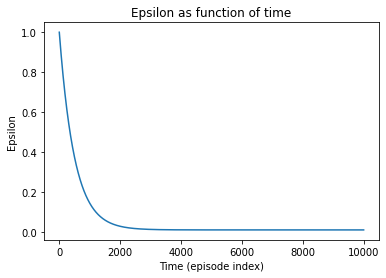

In [2]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Define epsilon as a function of time (episode index)

eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

# Note that the above lambda expression is equivalent to explicitly defining a function:
# def epsilon_episode(episode):
#     return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

plt.plot([eps_by_episode(i) for i in range(10000)])
plt.title('Epsilon as function of time')
plt.xlabel('Time (episode index)')
plt.ylabel('Epsilon')
plt.show()

# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [3]:
env_id = "CartPole-v0"
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)


def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [4]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon, env, device)
        
        # Take a step
        next_state, reward, done, _ = env.step(action)

        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

Agent training (episode18) Avg Reward 0.9444444444444444:   0%|          | 0/10001 [00:00<?, ?it/s]/root/RTML/2021JanRTML/lab14/myDQN.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode33) Avg Reward 0.9696969696969697:   0%|          | 0/10001 [00:00<?, ?it/s]<ipython-input-3-598cf8ec1259>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode10001) Avg Reward 0.9999000099990001: 100%|██████████| 10001/10001 [00:32<00:00, 305.93it/s]


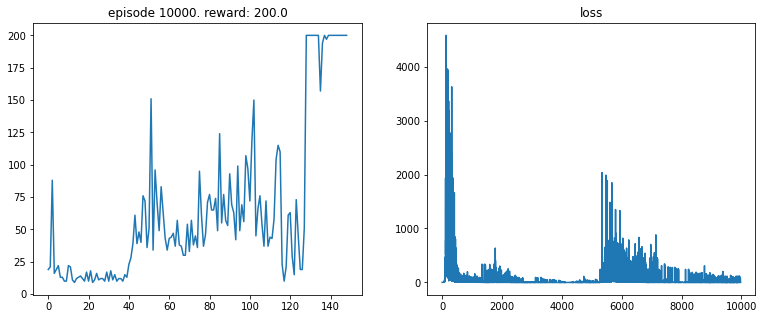

In [5]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

Agent training (episode23) Avg Reward -1.7687359186593874:   0%|          | 0/10001 [00:00<?, ?it/s]/root/RTML/2021JanRTML/lab14/myDQN.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode33) Avg Reward -1.386872202907794:   0%|          | 23/10001 [00:00<02:56, 56.43it/s]<ipython-input-3-598cf8ec1259>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode10001) Avg Reward -0.49263093280781484: 100%|██████████| 10001/10001 [00:40<00:00, 246.25it/s]


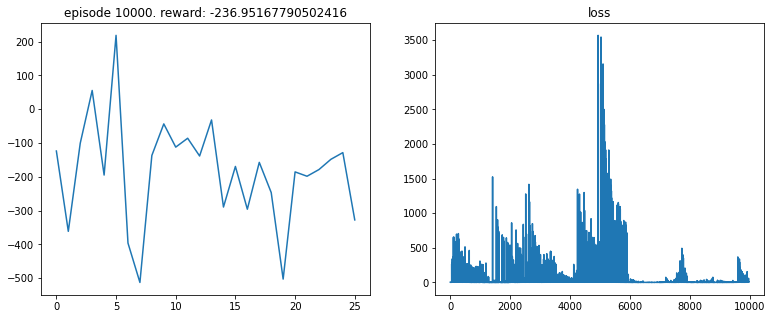

In [12]:
env_id = 'LunarLander-v2'
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model, all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

# torch.save(model.state_dict())

In [14]:
torch.save(model.state_dict(), 'checkpoints/LunarLander.pth')

## Applying DQN to Atari games

In [18]:
env_id = 'PongDeterministic-v4'
env = gym.make(env_id)

print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


In [19]:
import torchvision.transforms as T
from PIL import Image
image_size = 84

transform = T.Compose([T.ToPILImage(),  # from tensors to image data
                       T.Grayscale(num_output_channels=1), # convert to grayscale with 1 channel
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC), # resize to 84*84 by using Cubic interpolation
                       T.ToTensor()]) # convert back to tensor

def get_state(observation):
    # Numpy: Use transpose(a, argsort(axes)) to invert the transposition of tensors when using the axes keyword argument.
    # Example: x = np.ones((1, 2, 3))
    # np.transpose(x, (1, 0, 2)).shape --> (2, 1, 3)
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [20]:
model = DQN(image_size * image_size, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model

DQN(
  (layers): Sequential(
    (0): Linear(in_features=7056, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=6, bias=True)
  )
)

Agent training (episode33) Avg Reward 0.0:   0%|          | 0/10001 [00:00<?, ?it/s]<ipython-input-3-598cf8ec1259>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode50) Avg Reward 0.0:   0%|          | 48/10001 [00:00<02:25, 68.21it/s]/root/RTML/2021JanRTML/lab14/myDQN.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode10001) Avg Reward -0.022797720227977204: 100%|██████████| 10001/10001 [01:02<00:00, 159.71it/s]


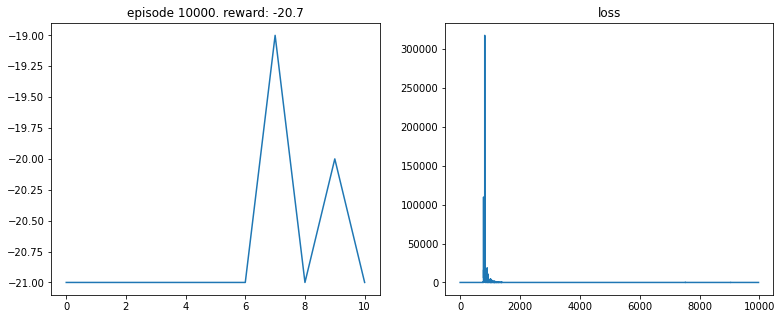

In [21]:
def train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    # convert observation state to image state, and reshape as 1D size
    state = get_state(obs).view(image_size * image_size)
    ######################################################
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon, env, device)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        # convert observation state to image state, and reshape as 1D size
        next_state = get_state(next_obs).view(image_size * image_size)
        ###################################################################
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            # convert observation state to image state, and reshape as 1D size
            state = get_state(obs).view(image_size * image_size)
            ###################################################################
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

model, all_rewards, losses = train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

In [22]:
torch.save(model.state_dict(), 'checkpoints/pong-v4.pth')

## Space Invader

Agent training (episode33) Avg Reward 0.0:   0%|          | 19/20001 [00:00<01:46, 187.80it/s]<ipython-input-3-598cf8ec1259>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode36) Avg Reward 0.0:   0%|          | 19/20001 [00:00<01:46, 187.80it/s]['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)
Agent training (episode20001) Avg Reward 0.24698765061746913: 100%|██████████| 20001/20001 [01:55<00:00, 173.81it/s]


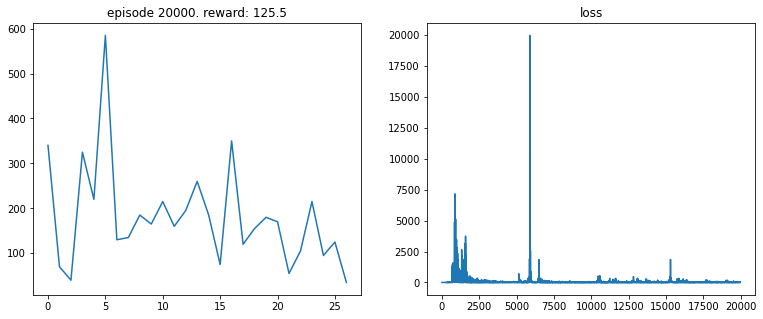

In [23]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)


model = DQN(image_size * image_size, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model, all_rewards, losses = train2(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 20000, batch_size=32, gamma = 0.99)

In [25]:
torch.save(model.state_dict(), 'checkpoints/spaceInvaders.pth')

## CNNDQN

In [12]:
import torchvision.transforms as T
from PIL import Image
image_size = 84
transform = T.Compose([T.ToPILImage(),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

# Convert to RGB image (3 channels)

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

# Train the DQN CNN

def train_CNNDQN(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    # change from get_state to get_state2
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon, env, device)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        # change from get_state to get_state2
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            # change from get_state to get_state2
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model, all_rewards, losses

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Agent training (episode1) Avg Reward 0.0:   0%|          | 0/50001 [00:00<?, ?it/s]['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)
Agent training (episode16) Avg Reward 0.0:   0%|          | 15/50001 [00:00<12:52, 64.68it/s]/root/RTML/2021JanRTML/lab14/myDQN.py:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode33) Avg Reward 0.0:   0%|          | 24/50001 [00:01<1:12:33, 11.48it/s]<ipython-input-3-8a3adac8a859>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode50001) Avg Reward 0.18529629407411852: 100%|██████████| 50001/50001 [07:54<00:00, 105.37it/s]


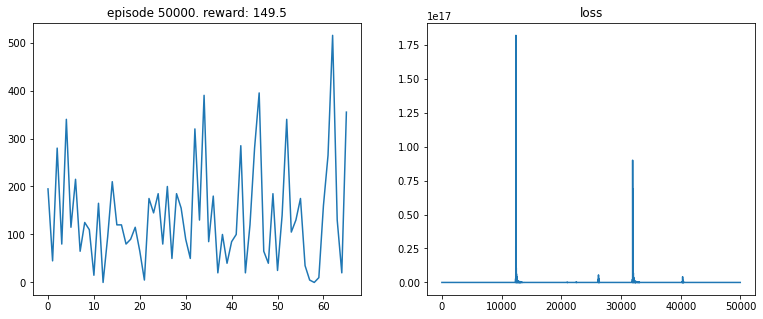

In [10]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)

model = CNNDQN(3, env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

model, all_rewards, losses = train_CNNDQN(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

In [16]:
torch.save(model.state_dict(), 'checkpoints/spaceInvaders-cnndqn.pth')

## Double DQN

In [17]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = CNNDQN(3, env.action_space.n).to(device)
target_model = CNNDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())
replay_buffer = ReplayBuffer(1000)

In [3]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
def compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma=0.99):     # from input only a model, you must input 2 models: current_model, and target_model
    # get data from replay mode
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    next_q_state_values = target_model(next_state)
    ############################################################

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    ############################################################################
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

def train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon, env, device)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma)    #######
            losses.append(loss.item())

        if episode % 500 == 0: # update target_model weight. The '500' is hyperparameter, you can change it as you want
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

Agent training (episode29) Avg Reward 0.0:   0%|          | 28/50001 [00:00<03:00, 277.44it/s]/root/RTML/2021JanRTML/lab14/myDQN.py:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode33) Avg Reward 0.0:   0%|          | 28/50001 [00:00<03:00, 277.44it/s]<ipython-input-17-721ae9420f10>:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode50001) Avg Reward 0.20149597008059839: 100%|██████████| 50001/50001 [07:47<00:00, 106.88it/s]


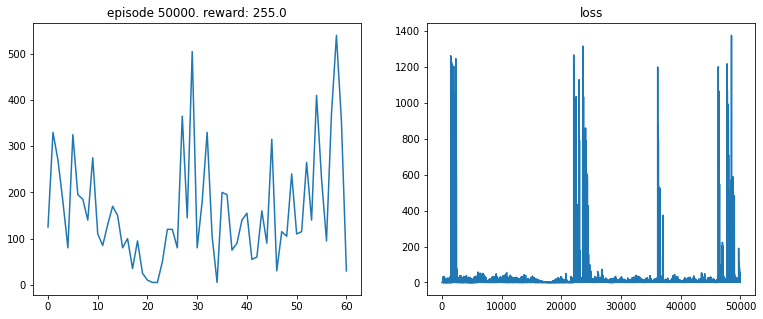

In [18]:
# Initialization
update_target(current_model, target_model)
current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

In [20]:
torch.save(current_model.state_dict(), 'checkpoints/spaceInvaders-doubledqn.pth')

## DDQNs

Agent training (episode33) Avg Reward 0.0:   0%|          | 0/50001 [00:00<?, ?it/s]<ipython-input-3-10b16b9674ce>:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode50001) Avg Reward 0.02019959600807984: 100%|██████████| 50001/50001 [07:52<00:00, 105.77it/s]


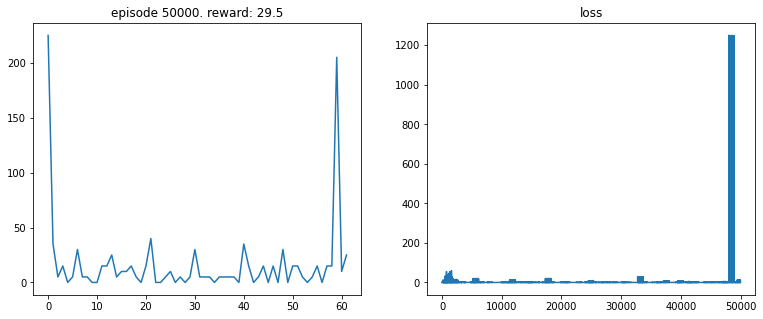

In [8]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(3, env.action_space.n).to(device)
target_model = DDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())
replay_buffer = ReplayBuffer(1000)



update_target(current_model, target_model)

current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

In [9]:
torch.save(current_model.state_dict(), 'checkpoints/spaceInvaders-ddqn.pth')

## Priority

In [3]:
episodes = 200000
batch_size = 64
gamma      = 0.99
min_play_reward = -.15

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = episodes / 10
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

# defind a function to return an increasing beta over episodes
beta_start = 0.4
beta_episodes = episodes / 10
def gen_beta_by_episode(beta_start, beta_episodes):
    beta_by_episode = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / beta_episodes)
    return beta_by_episode

beta_by_episode = gen_beta_by_episode(beta_start, beta_episodes)

In [4]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [5]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(3, env.action_space.n).to(device)
target_model  = DDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())

# Change from Normal replay buffer to be prioritize buffer
#replay_buffer = ReplayBuffer(100000)
replay_buffer = NaivePrioritizedBuffer(100000)

update_target(current_model, target_model)

In [6]:
import torchvision.transforms as T
from PIL import Image
image_size = 84
transform = T.Compose([T.ToPILImage(),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

# Convert to RGB image (3 channels)

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state
    
def compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma=0.99, beta=0.4):
    # get data from replay mode
    # state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)
    weights    = autograd.Variable(torch.FloatTensor(weights)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    #next_q_state_values = target_model(next_state)

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    #next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    # loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss

def train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = 10000, batch_size=32, gamma = 0.99, min_play_reward=-.15):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        avg_reward = tot_reward / (episode + 1)
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,avg_reward))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon, env, device)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            beta = beta_by_episode(episode)
            loss = compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma, beta)
            losses.append(loss.item())

        if episode % 500 == 0:
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [11]:
current_model, target_model, all_rewards, losses = train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = episodes, batch_size=batch_size, gamma = gamma, min_play_reward = min_play_reward)

NameError: name 'get_state2' is not defined

In [ ]:
torch.save(current_model.state_dict(), 'checkpoints/spaceInvaders-buffer.pth')